<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/suicide_risk_prediction_exp5_with_stop_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug 25 03:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [100]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Variables

In [5]:
model_name = "suicide_risk_analysis_model"
target_map = {'low_risk': 0, 'high_risk':1}
idx2newidx = {0:0,1:1,2:1,3:1}
checkpoint ="roberta-base"
num_labels=2


In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/data/sr_train_with_stopwords.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/sr_test_with_stopwords.csv')

In [7]:
train_df.label = train_df.label.map(idx2newidx)
test_df.label = test_df.label.map(idx2newidx)

In [8]:
train_df.to_csv('/content/drive/MyDrive/data/sr_binary_train.csv')
test_df.to_csv('/content/drive/MyDrive/data/sr_binary_test.csv')

### Hugging Face Creating Dataset Object

In [9]:
raw_datasets = load_dataset(
    'csv',
    data_files={'train':'/content/drive/MyDrive/data/sr_binary_train.csv',
                'test':'/content/drive/MyDrive/data/sr_binary_test.csv'}
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-017aa0a0a73edd36/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 461
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 119
    })
})

In [11]:
raw_datasets['train']['sent1'][0]

'stuck and hate it have zero confidence in myself my abilities my future stuck in dead end job that want badly to get out of but every time consider university courses or better more technical career choke and get terrified have no confidence that ll ever be able to get out of the state in now don want to be doing this for the rest of my life right now think the only thing keeping me alive is the fact that don want to put my parents through their son killing himself other than that my future seems hopeless and bleak not confident enough that can get the skills need to change it and just think dying would be so much easier than trying and failing to change everything'

In [12]:
raw_datasets['test']['sent1'][0]

'haven felt this way in years and jsut can deal with it anymore have no one absolutely no one my closest friend doesn want anything to do with me anymore because she thinks her boyfriend is cheating on her with methe guy was seeing doesn want to talk to me anymore because too dfucking boring for him or too crazy do nt even know do nt care to knowi so over iti just want to die so do nt have to be so alone anymore and try and wash oit down with wine and liquor or try to cover it with smile so donei just ca nt do it anymore'

### Tokenizer

In [13]:
from transformers import AutoTokenizer

In [14]:

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
tokenizer

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [16]:
#,batch['sent2']
def tokenize_fn(batch):
  return tokenizer(batch['sent1'],batch['sent2'], truncation=True, padding=True, max_length=512, add_special_tokens = True)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
tokenized_dataset['train']['input_ids'][0][0:10]

[0, 620, 5858, 8, 4157, 24, 33, 4276, 2123, 11]

In [18]:
#tokenized_dataset['train']['token_type_ids'][0][0:10]

In [19]:
tokenized_dataset['train']['label'][0:3]

[1, 1, 1]

In [ ]:
tokenizer.decode(tokenized_dataset['train']['input_ids'][0])

### Config File for the Model 

In [21]:
from torch import nn 
from transformers import AutoConfig
config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels)

In [22]:
config.id2label = {v:k for k,v in target_map.items()}
config.id2label

{0: 'low_risk', 1: 'high_risk'}

In [23]:
config.label2id = target_map
config.label2id

{'low_risk': 0, 'high_risk': 1}

In [24]:
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "low_risk",
    "1": "high_risk"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "high_risk": 1,
    "low_risk": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

### Loading the Model for Classification

In [25]:
from transformers import AutoModelForSequenceClassification
import torch

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config).to(device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
model

### Testing Model

In [28]:
##tokenized data 
sample_text1 = raw_datasets['train']['sent1'][0]
sample_text2 = raw_datasets['train']['sent2'][0]
sample = tokenizer(sample_text1,sample_text2, truncation=True,padding='max_length', return_tensors='pt',max_length=512)
sample.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
#model.resize_token_embeddings(len(tokenizer))

In [ ]:
tokenizer.decode(sample['input_ids'][0])

In [31]:
sample_label = raw_datasets['train']['label'][0]
print(f'sample label {sample_label}')
sample_label = torch.tensor(sample_label, dtype=torch.long)
type(sample_label)

sample label 1


torch.Tensor

In [32]:
preds_distilebert= model(sample['input_ids'].to(device))
preds_distilebert

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0801, -0.1280]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training Arguments

In [33]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
## Training Arguments
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
training_args = TrainingArguments(
    model_name,
    evaluation_strategy='epoch',
    num_train_epochs=6,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

### Compute Metric Function

In [34]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

### Trainer Object

In [35]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

### Training 

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.566200,0.451000,0.739496,"(0.6287500507449357,)"
2,0.426700,0.381165,0.882353,"(0.874203279326619,)"
3,0.291800,0.356723,0.882353,"(0.8823529411764706,)"
4,0.312900,0.349440,0.873950,"(0.8757655129637449,)"
5,0.186200,0.396154,0.890756,"(0.8841381733723574,)"
6,0.151800,0.398576,0.890756,"(0.8913111911431238,)"


TrainOutput(global_step=174, training_loss=0.3166866384703538, metrics={'train_runtime': 124.8247, 'train_samples_per_second': 22.159, 'train_steps_per_second': 1.394, 'total_flos': 727765179125760.0, 'train_loss': 0.3166866384703538, 'epoch': 6.0})

### Loading in the Checkpoints

In [37]:
!ls -ltra suicide_risk_analysis_model

total 36
drwxr-xr-x 1 root root 4096 Aug 25 03:34 ..
drwxr-xr-x 3 root root 4096 Aug 25 03:34 runs
drwxr-xr-x 2 root root 4096 Aug 25 03:34 checkpoint-29
drwxr-xr-x 2 root root 4096 Aug 25 03:34 checkpoint-58
drwxr-xr-x 2 root root 4096 Aug 25 03:35 checkpoint-87
drwxr-xr-x 2 root root 4096 Aug 25 03:35 checkpoint-116
drwxr-xr-x 2 root root 4096 Aug 25 03:35 checkpoint-145
drwxr-xr-x 9 root root 4096 Aug 25 03:36 .
drwxr-xr-x 2 root root 4096 Aug 25 03:36 checkpoint-174


### Creating a Pipeline for Prediction

In [38]:
from transformers import pipeline

In [39]:
#loading the trained model with a specific checkpoint
savedmodel = pipeline('text-classification',
                      model='suicide_risk_analysis_model/checkpoint-174',
                      device=0)

In [40]:
savedmodel.tokenizer

PreTrainedTokenizerFast(name_or_path='suicide_risk_analysis_model/checkpoint-174', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [77]:
test_inx=[]
actual_label=[]
for i in range(len(raw_datasets['test'])):
  try:
    test_pred = savedmodel(raw_datasets['test']['sent1'][i], raw_datasets['test']['sent2'][i])
    actual_label.append(raw_datasets['test']['label'][i])
    test_inx.append(test_pred)
  except:
    continue


In [79]:
test_inx = [i[0]['label'] for i in test_inx ]

In [82]:
test_inx = [target_map[k] for k in test_inx ]


In [88]:
test_inx[0:2]

[1, 0]

In [64]:
len(raw_datasets['test']['sent1'])

119

In [70]:
len(actual_label)

108

In [74]:
test_inx

[1]

### Model Evaluation

In [84]:
cm = confusion_matrix(actual_label, test_inx, labels=[0, 1])

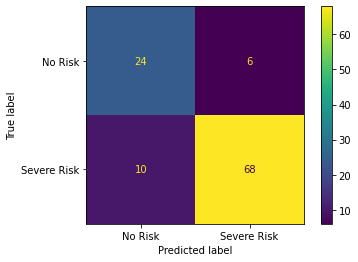

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['No Risk','Severe Risk'])
disp.plot()
plt.grid(False)
plt.show()

In [87]:
print(classification_report(actual_label, test_inx))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        30
           1       0.92      0.87      0.89        78

    accuracy                           0.85       108
   macro avg       0.81      0.84      0.82       108
weighted avg       0.86      0.85      0.85       108



### Error Analysis

In [89]:
f"suicide_risk_analysis_model/checkpoint-174"

'suicide_risk_analysis_model/checkpoint-174'

In [90]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [91]:
from torch.nn.functional import cross_entropy
def forward_pass_with_custom_model(batch):
    #place all input tensors on the device 
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #call the model
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"].to(device) , attention_mask=inputs["attention_mask"].to(device), labels=batch["label"].to(device))
        #get the logits
        logits = outputs.logits
        pred_labels = logits.argmax(-1)
        loss = cross_entropy(logits, batch["label"].to(device), reduction="none") #shape of logits is (batch_size, num_labels) and shape of batch["label"] is (batch_size)
        #place the outputs on the CPU for compatibility with the other dataset columns  
        return {"pred_labels": pred_labels.cpu().numpy(),"batch_loss": loss.cpu().numpy() }

In [92]:
#convert dataset to pytocrch tensors
tokenized_dataset.set_format("torch", columns=["input_ids","attention_mask" ,"label"])
#Compute loss values
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_custom_model, batched=True, batch_size=16)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [93]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask'],
        num_rows: 461
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Unnamed: 0.1', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask', 'pred_labels', 'batch_loss'],
        num_rows: 119
    })
})

In [94]:
index2tag = {0:'low_risk',1:'high_risk'}

In [95]:
tokenized_dataset.set_format("pandas")
cols = ["sent1","sent2","label","pred_labels","batch_loss"]
df_test= tokenized_dataset["test"][:][cols]
df_test['label'] = df_test["label"].map(index2tag)
df_test['pred_labels']=df_test['pred_labels'].map(index2tag)

In [96]:
df_test.head()

,sent1,sent2,label,pred_labels,batch_loss
0,haven felt this way in years and jsut can deal with it anymore have no one absolutely no one my closest friend doesn want anything to do with me anymore because she thinks her boyfriend is cheating on her with methe guy was seeing doesn want to talk to me anymore because too dfucking boring for him or too crazy do nt even know do nt care to knowi so over iti just want to die so do nt have to be so alone anymore and try and wash oit down with wine and liquor or try to cover it with smile so donei just ca nt do it anymore,-100,high_risk,high_risk,0.008286
1,for few months my cousin has told me how he doesn want to live anymore he said he made pact on his th birthday that if he not happy he will kill himself his th birthday is tomorrow ve been there for him through this whole thing stayed up all night just talking to him many nights he texted me last week saying he was sitting in van with rope ready to do it his girlfriend contacted me saying he sent her goodbye message and she was scared and the only person she can think to talk to because seem to be the only one he can talk to managed to get him to go home and sleep it off after ringing his dad and even ringing the suicide line which rang him to speak to him he went to cliff area two days ago and just sat there for hours contemplating jumping but someone saw him and sat next to him person know nothing can say can change his mind but if he doesn anything am going to feel like there was something could of done is there anything can say to change his mind ve begged him to go to the doctors but he has no faith in them ve begged him to speak to his dad but he said he can scared of losing him scared of it turning my family upside down scared it will break my uncle and aunties heart and terrified that will live with the guilt that could of done more he might not even do it hope he doesn guess just needed to speak my mind to strangers,-100,high_risk,low_risk,3.986617
2,my friend just tried to hang himself he called me saying he was on the roof of the parking garage and tied noose went and picked him up and brought him back home and kept him on the line until got to him he on my couch trying to reach his parents now but can not sure what supposed to do please help,-100,low_risk,low_risk,0.021407
3,my whole body is shaking while write this burning my chest is burning nothing stops it nothing soothes it how long do have to burn in penance for this it would be easy on the fourth floor,-100,high_risk,high_risk,0.023142
4,hello everyone over the past few months ve been talking to guy who goes to my school we ve talked lot over that time and he been hinting at depression but this night he told me he contemplating suicide and he had already cut his wrists told him about the counselor at school and convinced him to put thinking of suicide to one side for some time very frightened and don know how can help can anyone help from what ve seen of him he seems to have dependency issues as he feels no one can help him from this believe he built tough outer shell and the horrible thing is not sure can get past it since ve only known him for less than year should call the school about it not sure if they would even take him seriously he acts happy quite convincingly and that could only make it worse what should do thank you for anyone helping,-100,low_risk,low_risk,0.016292


In [97]:
df_test.query('label!=pred_labels').head()

,sent1,sent2,label,pred_labels,batch_loss
1,for few months my cousin has told me how he doesn want to live anymore he said he made pact on his th birthday that if he not happy he will kill himself his th birthday is tomorrow ve been there for him through this whole thing stayed up all night just talking to him many nights he texted me last week saying he was sitting in van with rope ready to do it his girlfriend contacted me saying he sent her goodbye message and she was scared and the only person she can think to talk to because seem to be the only one he can talk to managed to get him to go home and sleep it off after ringing his dad and even ringing the suicide line which rang him to speak to him he went to cliff area two days ago and just sat there for hours contemplating jumping but someone saw him and sat next to him person know nothing can say can change his mind but if he doesn anything am going to feel like there was something could of done is there anything can say to change his mind ve begged him to go to the doctors but he has no faith in them ve begged him to speak to his dad but he said he can scared of losing him scared of it turning my family upside down scared it will break my uncle and aunties heart and terrified that will live with the guilt that could of done more he might not even do it hope he doesn guess just needed to speak my mind to strangers,-100,high_risk,low_risk,3.986617
15,will be available from now until ish person survivor of abuse and have worked through similar feelings feel free to email me about anything you want to talk about am here for you you do not have to feel alone,thought after good night sleep would feel better still feel like drowning and don see way out someone please help sorry that can explain better can think through all of the tears,low_risk,high_risk,3.902212
16,the struggle to not cry and the chest pain with it they re constant every day can write can sleep can accomplish anything where need to focus or relax can barely keep up with school every night struggle against the pain to fall asleep hoping that when do won wake up feel trapped in my circumstances can look for help convinced don deserve better need the aching to go away can deal with feeling hopeless think just need the physical pain to stop so can try to keep living,-100,low_risk,high_risk,4.922919
27,in truth think of candy store sparkling as though children were meant to enter but not soul is here inside for when you peer inside the plane windows it seems the owner too has to hide you know you shouldn enter as it getting quite late but you forget the troubles over and don even hesitate but as you slowly step inside and feel that nothing wrong the music comes to life the stores eerie song the lights begin to dim your eyes space apart you suddenly know to leave there chill left in your heart but when you reach the cold steel door the handle you found is broken and only the residing sweets you ve swallowed are your main residing token so you slide down and sit and stay and wish and pray and spit and scream oh shit for the doors they still won open you re now trapped inside and all hope has been lost nowhere to run and hide but when you feel like giving up you hear small click for the doors have just unlocked and the worlds come back so quick and as you take your steps outside slowly start to dare you take reluctant breath of what you confirm to be fresh air and shakily your feet find ground as you leave the store again to run back straight home telling no one where you ve been for who would really believe you person inside magic store you ve never told anyone of the place not thought to enter it before but in truth you did give it shot and enter into its steel doors for it was not fate money or pressure that put you in there but truly your own accord will you attempt to enter the store again well now who really knows for like the changing of the seasons sense comes and goes so your left wondering this question will 

In [99]:
df_test.query("label=='Severe Risk' & pred_labels=='Moderate Risk'")

,sent1,sent2,label,pred_labels,batch_loss
